In [2]:
import numpy as np
import pandas as pd
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import TensorBoard
import  tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load and preprocess data

In [3]:
data = pd.read_csv('data.csv')
data.head()

,national,south,north,east,central,west,timestamp
0,47,44,37,47,47,34,2016-02-07T18:00:00+08:00
1,59,57,54,59,57,56,2016-02-08T23:00:00+08:00
2,59,57,55,59,57,56,2016-02-09T01:00:00+08:00
3,59,57,55,59,56,56,2016-02-09T02:00:00+08:00
4,59,58,55,59,56,56,2016-02-09T03:00:00+08:00


here we check for null or missing values

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30022 entries, 0 to 30021
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   national   30022 non-null  int64 
 1   south      30022 non-null  int64 
 2   north      30022 non-null  int64 
 3   east       30022 non-null  int64 
 4   central    30022 non-null  int64 
 5   west       30022 non-null  int64 
 6   timestamp  30022 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.6+ MB


and to get a sense of data we should have a look at distributions

In [5]:
data.describe()

,national,south,north,east,central,west
count,30022.000000,30022.000000,30022.000000,30022.000000,30022.000000,30022.000000
mean,50.502232,54.294351,54.003464,52.491007,52.885884,50.299014
std,13.107219,10.844489,10.991413,10.365553,11.832203,11.672157
min,13.000000,20.000000,19.000000,14.000000,13.000000,16.000000
25%,42.000000,50.000000,49.000000,47.000000,47.000000,43.000000
50%,53.000000,54.000000,55.000000,54.000000,54.000000,52.000000
75%,58.000000,59.000000,59.000000,58.000000,59.000000,57.000000
max,143.000000,154.000000,145.000000,131.000000,154.000000,143.000000


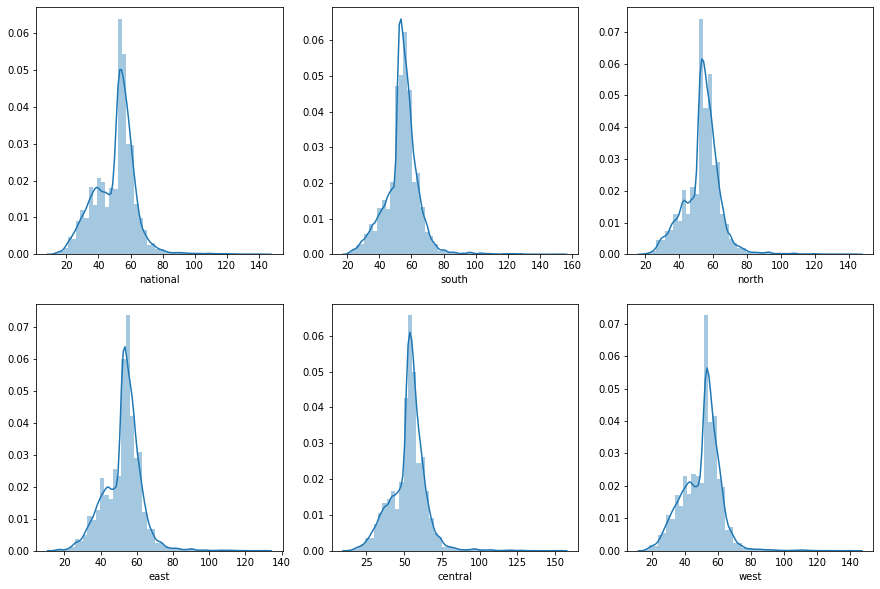

In [6]:
fig, axarr = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
    for j in range(3):
        sns.distplot(data[data.columns[i*3+j]], ax=axarr[i, j])

drop timestamp column(order of samples will not change) and split data to train and test

In [0]:
data = data.drop('timestamp', axis=1)
train = data[:int(0.7*data.shape[0])]
test = np.array(data[int(0.7*data.shape[0]):].values)

scale features between 0 and 1 

In [0]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train)

There are so many ways we could use this data to get some insights. here we take _lag_size_ past days to predict _pred_steps_ days ahead. so we generate a dataset of such samples. we can train a model to predict each feature or a model predict all features at once. we go with the former one and take the first feature just to test

In [0]:
lag_size = 14
pred_steps = 3

x_train = []
y_train = []


for i in range(lag_size, train_scaled.shape[0]-pred_steps):
    x_train.append(train_scaled[i-lag_size: i, 0])
    y_train.append(train_scaled[i: i+pred_steps, 0])
    
x_train, y_train = np.expand_dims(x_train, 2), np.expand_dims(y_train, 2)

In [14]:
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)

x_train.shape = (20998, 14, 1)
y_train.shape = (20998, 3, 1)


In [0]:
# Using the same scaler to transform test samples. 
test_scaled = scaler.transform(test)

In [0]:
x_test = []
y_test = []

for i in range(lag_size, test_scaled.shape[0]-pred_steps):
    x_test.append(test_scaled[i-lag_size: i, 0])
    y_test.append(test_scaled[i: i+pred_steps, 0])
    
x_test, y_test = np.expand_dims(x_test, 2), np.expand_dims(y_test, 2)

In [17]:
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_test.shape = (8990, 14, 1)
y_test.shape = (8990, 3, 1)


# Define model

In [0]:
latent_dim = 256
tf.keras.backend.clear_session()
# Define an input sequence and process it.
encoder_inputs = Input(shape=(lag_size, x_train.shape[-1]), name='enc_inp')
encoder = LSTM(latent_dim, return_state=True, name='enc_lstm')
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=((None, 1)), name='dec_inp')
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='dec_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
# decoder_dense = TimeDistributed(Dense(1, activation='sigmoid'), input_shape=(y_train.shape[1], y_train.shape[2]))
decoder_dense = Dense(1, activation='sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
model.compile(optimizer='rmsprop', loss='mse')

In [212]:
model.build(input_shape=x_train.shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_inp (InputLayer)            [(None, 14, 1)]      0                                            
__________________________________________________________________________________________________
dec_inp (InputLayer)            [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
enc_lstm (LSTM)                 [(None, 256), (None, 264192      enc_inp[0][0]                    
__________________________________________________________________________________________________
dec_lstm (LSTM)                 [(None, None, 256),  264192      dec_inp[0][0]                    
                                                                 enc_lstm[0][1]               

# Train Model

In [213]:
batch_size = 2**11
epochs = 500

# shift output by 1 and add the last input to output
y_train_shifted = np.zeros(y_train.shape)
y_train_shifted[:, 1:, :] = y_train[:, :-1, :]
y_train_shifted[:, 0, :] = x_train[:, -1, 0].reshape((-1, 1))   

model.fit([x_train, y_train_shifted], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.2
                    )


Epoch 1/500
9/9 [==============================] - 1s 140ms/step - loss: 0.0257 - val_loss: 0.0085
Epoch 2/500
9/9 [==============================] - 0s 51ms/step - loss: 0.0134 - val_loss: 0.0086
Epoch 3/500
9/9 [==============================] - 0s 50ms/step - loss: 0.0119 - val_loss: 0.0073
Epoch 4/500
9/9 [==============================] - 0s 47ms/step - loss: 0.0090 - val_loss: 0.0063
Epoch 5/500
9/9 [==============================] - 0s 48ms/step - loss: 0.0051 - val_loss: 0.0172
Epoch 6/500
9/9 [==============================] - 0s 48ms/step - loss: 0.0073 - val_loss: 0.0139
Epoch 7/500
9/9 [==============================] - 0s 48ms/step - loss: 0.0062 - val_loss: 0.0024
Epoch 8/500
9/9 [==============================] - 0s 47ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 9/500
9/9 [==============================] - 0s 49ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 10/500
9/9 [==============================] - 0s 48ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 11/500
9/9 [

# Inference

In [0]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hbang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((input_seq.shape[0], 1, 1))
    
    target_seq[:, 0, 0] = input_seq[:, -1, 0]

    decoded_seq = np.zeros((input_seq.shape[0], pred_steps, 1))
    
    for i in range(pred_steps):
        output, h, c = decoder_model.predict([target_seq] + states_value)
        decoded_seq[:, i, 0] = output[:, 0, 0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((input_seq.shape[0], 1, 1))
        target_seq[:, 0, 0] = output[:, 0, 0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [0]:
def plot_samples(X, Y, rows, cols):
    fig, axarr = plt.subplots(rows, cols, figsize=(15, 15))
    pred = decode_sequence(X)

    for i in range(rows):
        for j in range(cols):
            idx = np.random.randint(0, X.shape[0])

            axarr[i, j].plot(np.arange(lag_size), X[idx,:, 0])
            axarr[i, j].plot(np.arange(lag_size, lag_size+pred_steps), Y[idx], label='original')
            axarr[i, j].plot(np.arange(lag_size, lag_size+pred_steps), pred[idx].ravel(), label='prediction')

    plt.legend()

Now let's evaluate our model.

some random test samples


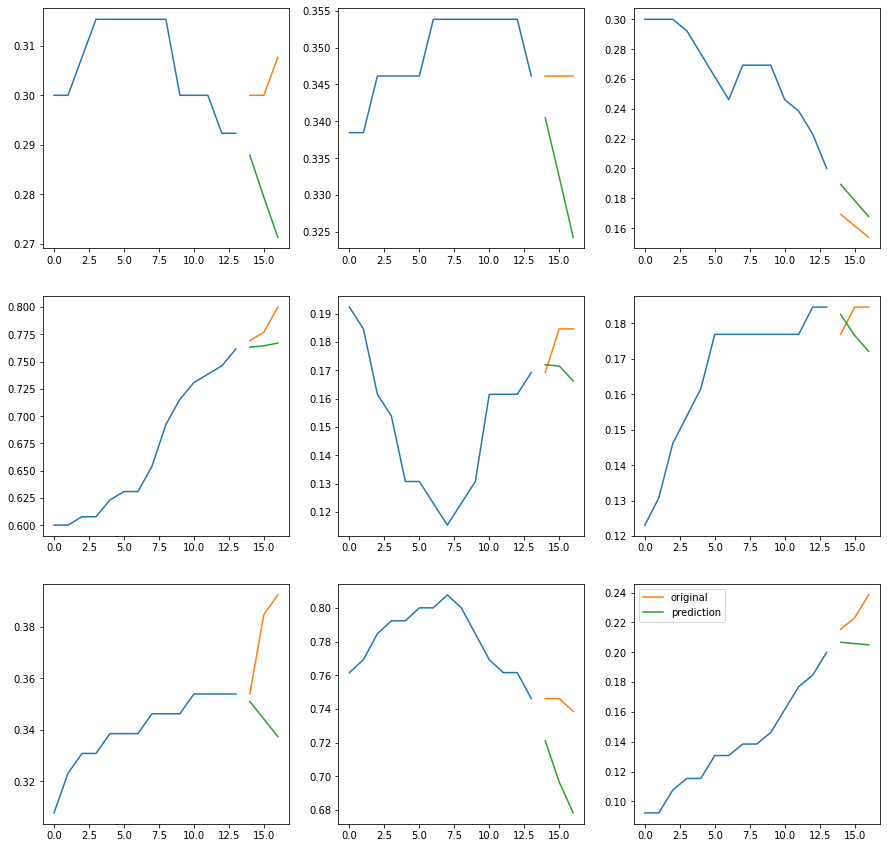

In [216]:
print('some random test samples')
plot_samples(x_test, y_test, 3, 3)

some random train samples


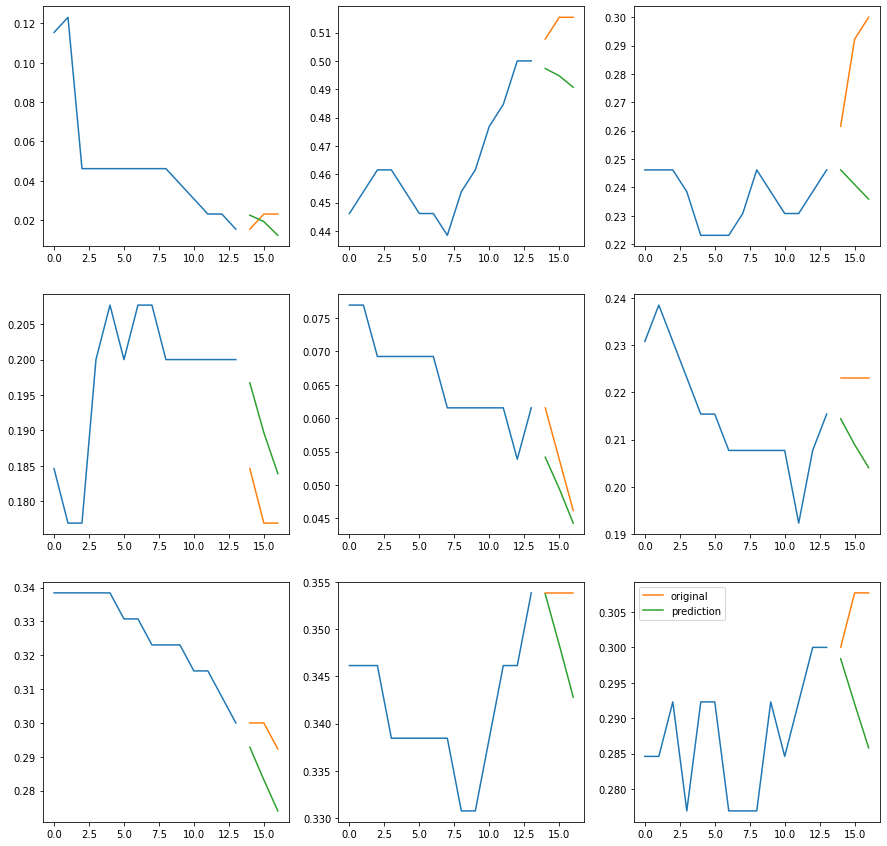

In [218]:
print('some random train samples')
plot_samples(x_train, y_train, 3, 3)

here we evaluate encoder module

In [0]:
encoded = encoder_model.predict(x_test)[0]

calculate cosine distance between encoded representations of test samples.


In [0]:
from scipy.spatial.distance import pdist, squareform
dist = squareform(pdist(encoded, metric='cosine'))

In [0]:
argsrt = np.argsort(dist.flatten())

In [276]:
argmx = np.unravel_index(argsrt[9500], dist.shape)    ## first elements of dist is 0, skip that
argmx

(7298, 8574)

In [277]:
dist[argmx[0], argmx[1]]

1.3882628475236913e-05

as below figure suggests, encoder module perform a good job at extracting representation. these two have high similarity between the representations as well as the original data

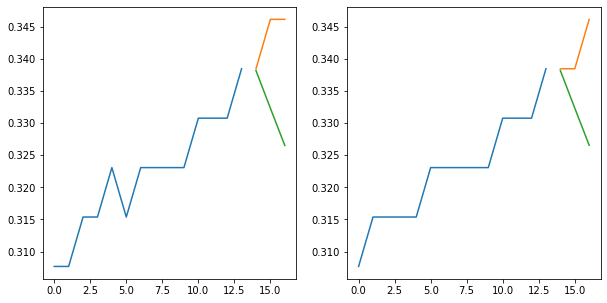

In [278]:
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
idx = argmx[0]
pred = decode_sequence(x_test[idx].reshape((1, lag_size, 1)))

axarr[0].plot(np.arange(lag_size), x_test[idx,:, 0])
axarr[0].plot(np.arange(lag_size, lag_size+pred_steps), y_test[idx], label='original')
axarr[0].plot(np.arange(lag_size, lag_size+pred_steps), pred.ravel(), label='prediction')

idx = argmx[1]
pred = decode_sequence(x_test[ idx].reshape((1, lag_size, 1)))

axarr[1].plot(np.arange(lag_size), x_test[idx,:, 0])
axarr[1].plot(np.arange(lag_size, lag_size+pred_steps), y_test[idx], label='original')
axarr[1].plot(np.arange(lag_size, lag_size+pred_steps), pred.ravel(), label='prediction')

now we should consider numerical metrics to evaluate the model

In [246]:
def eval_model(X, Y):
  pred = decode_sequence(X)
  return np.mean(tf.keras.losses.mse(pred, Y), axis=1)

mse = eval_model(x_test, y_test)
np.mean(mse)

0.00031018091169835

there are some perfect predictions on test set. (change the idx)

7.175604040115512e-07


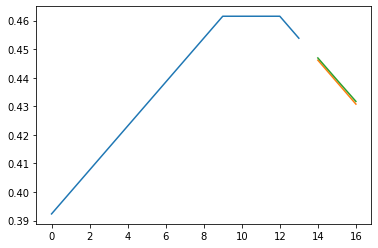

In [279]:
idx = np.argsort(mse)[10]
print(mse[idx])
pred = decode_sequence(x_test[idx].reshape((1, lag_size, 1)))


plt.plot(np.arange(lag_size), x_test[idx,:, 0])
plt.plot(np.arange(lag_size, lag_size+pred_steps), y_test[idx], label='original')
plt.plot(np.arange(lag_size, lag_size+pred_steps), pred.ravel(), label='prediction')